# import sm2r_tahmo_algorithm
import extract_ascat_rzsm
import utils

import os
import pandas as pd
import numpy as np
import xarray as xr
import eumdac
import datetime
from datetime import datetime, timedelta
import shutil
import requests
import ftplib
import calendar
import geopandas as gpd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import scipy.stats as stats
from scipy.stats.mstats import mquantiles
from scipy.interpolate import interp1d
from sklearn.metrics import confusion_matrix
import pickle
import warnings
import re

# Ignore the specific RuntimeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)


# Settings

In [13]:
path_to_ascat_rzsm = r"/scratch/b/b382028/sm2rain/data/ascat_daily_sm/"
path_to_tahmo = 'data/tahmo'
path_to_metadata = 'data/tahmo/metadata.csv'


# [MinLon,MaxLon,MinLat,MaxLat] =  [28.45,43.55,-5.05,5.45]
[MinLon,MaxLon,MinLat,MaxLat] =  [-4.63,8.33,4.06,15.10]

tol = 0.2

nclasses = 7
min_value = 0
max_value = 1800

sigma=5.0

ID = 'WA'
num_stations_to_select = 'All' #'All' # 'All' #'All' or int

days = list(np.arange(1,32))
months =list(np.arange(1,13))#list(np.arange(1,12)) 
year = 2023

login = ""
password = ""

#### Select product

In [14]:
if year >= 2022:
    product = 'h26'
    print('ASCAT h26 will be used for SM2Rain')
if 2019 <= year < 2022:
    product = 'h142'
    print('ASCAT h142 will be used for SM2Rain')
if 1992 <= year < 2019:
    product = 'h141'
    print('ASCAT h141 will be used for SM2Rain')
if year < 1992:
    print('No product for selected year')
    

ASCAT h26 will be used for SM2Rain


## Extract ASCAT RZSM

In [4]:
filename, file_path = extract_ascat_rzsm.download_ascat_rzsm(path_to_ascat_rzsm+str(year), days, months, year, login, password)
print(f'ASCAT RZSM files saved in {file_path}')

ASCAT RZSM files saved in /scratch/b/b382028/sm2rain/data/ascat_daily_sm/2021/h142_2021123100_R01.nc


# Preprocessing

### Prepare ASCAT Root Zone Soil Moisture (H26, H141 or H142)

In [15]:
def preprocess_coordinates(ds):
    """
    Assign the coordinates of ds_first to all timesteps. (Some timesteps in h26 ascat rzsm datasets have very slighty different coordinates)
    
    ds: xarray dataset
    
    Returns xarray dataset
    """
    ds['lat'] = np.around(ds_first['lat'].values, 2)
    ds['lon'] = np.around(ds_first['lon'].values, 2)
    
    return ds

In [16]:
ascat_file_name = f'{product}_{year}010100_R01.nc'  
ds_first = xr.open_dataset(os.path.join(path_to_ascat_rzsm+str(year),ascat_file_name)) #Open first dataset for specifying the lon lat coordinates

DS = xr.open_mfdataset(os.path.join(path_to_ascat_rzsm+str(year), '*.nc'), preprocess=preprocess_coordinates, parallel=True) #Merge all datasets and assign the coordinates of ds_first to all days

DS = DS.assign_coords(lon=(DS.lon + 180) % 360 - 180) #convert ascat coordinates from 360 system to 180
DS = DS.sortby('lat')
DS = DS.sortby('lon')

DS_subset = DS.sel(lat=slice(MinLat,MaxLat), lon=slice(MinLon,MaxLon)) #Make subset

#### Export merged ASCAT SM data

In [18]:
# year_first = DS_subset.time.values[0].astype('datetime64[Y]').astype(int)  + 1970
# year_last = DS_subset.time.values[-1].astype('datetime64[Y]').astype(int)  + 1970
# years = np.unique(np.arange(year_first, year_last+1))

# for year in years:
#     DS_subset['var40'].sel(time=DS_subset.time.dt.year.isin([year])).to_netcdf(f'data/ascat_{product}_sm_{year}_R01_subset.nc') # Export data per year
# DS_subset = xr.open_dataset('data/soilmoisture_subsets/ascat_h26_sm_2022_R01_subset.nc')
DS_subset['var40'].to_netcdf('data/soilmoisture_subsets/ascat_h142_sm_2023_R01_subset_westafrica.nc')
# DS_subset

### Prepare TAHMO data

In [218]:
list_stations = []
data_folder = path_to_tahmo

### Create list of all tahmo stations
for i in range(len(os.listdir(data_folder))):
    data_dir = os.path.join(data_folder, os.listdir(data_folder)[i])
    if os.path.basename(data_dir).startswith('TA'):
        station_name = os.path.basename(data_dir).split('.')[0]
        list_stations.append(station_name)

# Select the stations that are located within the subset
list_stations_subset = utils.SelectStationsSubset(list_stations, path_to_metadata, MinLat, MaxLat, MinLon, MaxLon) ### Select all stations within subset

#### Create dictionary with rainfall data per station

In [219]:
data_folder = path_to_tahmo
prec_ts_stations = {}

## Create dictionary of rainfall data per station
for i in range(len(os.listdir(data_folder))):
    data_dir = os.path.join(data_folder, os.listdir(data_folder)[i])
    if os.path.basename(data_dir).startswith('TA'):
        station_name = os.path.basename(data_dir).split('.')[0]
        if station_name in list_stations_subset:
            station_data = pd.read_csv(data_dir, index_col=0, parse_dates=True)
            # prec_ts_stations[station_name] = station_data.precip.loc[station_data.index.year==year]
            nan_count = np.count_nonzero(np.isnan(station_data.precip.loc[station_data.index.year==year]))
            if (nan_count / len(station_data.precip.loc[station_data.index.year==year])) < tol:
                prec_ts_stations[station_name] = station_data.precip.loc[station_data.index.year==year]

### Create dictionary with SM data at stations

In [221]:
sm_ts_stations = utils.timeSeriesAllTahmoFromNetCDF(f'data/soilmoisture_subsets/ascat_{product}_sm_{year}_R01_subset.nc', path_to_metadata, list_stations_subset, 'var40') #SM timeseries per TAHMO station (0-7cm depth)

if product == 'h26':
    sm_ts_stations = utils.remove_multiindex(sm_ts_stations) ## Clean index (only needed in h26 product)

sm_ts_stations = {key: value for key, value in sm_ts_stations.items() if key in prec_ts_stations}

# Create rainfall classes

In [222]:
path_to_ascat_file = f'data/soilmoisture_subsets/ascat_{product}_sm_{year}_R01_subset.nc'

rainfall_grid, rainclass_dic = utils.create_rainfall_class_grid(path_to_tahmo, path_to_metadata, path_to_ascat_file, list_stations_subset, min_value, max_value, nclasses)

rainclass_dic = {key: value for key, value in rainclass_dic.items() if key in prec_ts_stations}

### Select subset for calibration/validation

In [223]:
rainclass_dic_subset, unselected_stations = utils.select_subset_stations(rainclass_dic, num_stations_to_select)

In [117]:
# rainclass_dic_subset
file_path = f'selected_stations_{ID}.pkl'

with open(file_path, 'wb') as file:
    pickle.dump(rainclass_dic_subset, file)

# Calibration

In [224]:
#Calibrate the parameters per rainclass. TO DO: allow for varying rainfall classes
param_dic = sm2r_tahmo_algorithm.RainfallClass_params(nclasses, rainclass_dic_subset, prec_ts_stations, sm_ts_stations, 400, x0=None, bounds=None, options=None, method='TNC')


# SM2Rain

### Assign SM2R parameters to grid

In [204]:
param_grid = sm2r_tahmo_algorithm.assign_sm2rparams_to_grid(path_to_ascat_file, path_to_metadata=None, param_dic_calibrated=param_dic, param_grid_rainclass=rainfall_grid, rainclass=True, sigma = sigma)

In [46]:
param_grid.to_netcdf('/home/b/b382028/SUPER/data/param_grid_2018_2022.nc')

In [225]:
water_body_mask = np.isnan(DS_subset_sm2r) 
param_grid_regridded = param_grid.interp_like(water_body_mask)

# param_grid = param_grid.where(~water_body_mask[0])

for var_name in param_grid_regridded.variables:
    if var_name not in param_grid_regridded.coords:  # Exclude coordinate variables
        param_grid_regridded[var_name] = param_grid_regridded[var_name].where(~water_body_mask['precip'])

In [226]:
np.nanmax(param_grid_regridded['smoothed_a'].values)

14.588076755352342

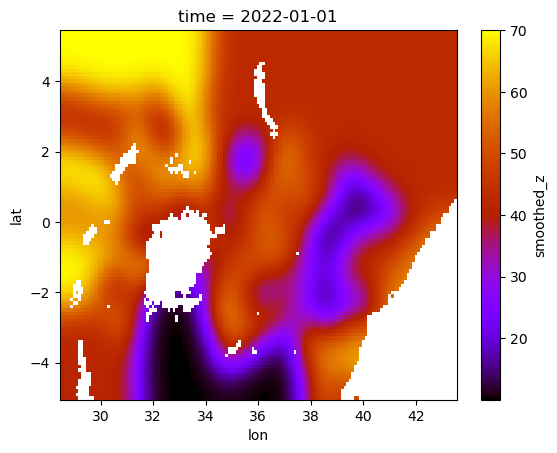

In [227]:
param_grid_regridded['smoothed_z'][:,:,0].plot(cmap='gnuplot')

### Generate precip timeseries

In [45]:
DS_subset_sm2r =  sm2r_tahmo_algorithm.ts_sm2rain_grid(param_grid, 'data/ascat_h26_sm_2022_R01_subset.nc', smoothed=True)


#### Export results

In [38]:
DS_subset_sm2r['precip'].to_netcdf(f'data/ascat_{product}_sm2r_{year}_R01_rainclass_smoothed_{num_stations_to_select}_stations_{ID}.nc')

#### Export

In [355]:
sm2rain_corrected['precip'].to_netcdf(f'data/ascat_{product}_sm2r_{year}_R01_rainclass_smoothed_corrected.nc')

# Visualize

In [39]:
kenya = gpd.read_file(r'/home/b/b382028/sm2rain/data/shapes/kenya/gadm41_KEN_0.shp')
rwanda = gpd.read_file(r'/home/b/b382028/sm2rain/data/shapes/rwanda/gadm41_RWA_0.shp')
uganda = gpd.read_file(r'/home/b/b382028/sm2rain/data/shapes/uganda/gadm41_UGA_0.shp')
tanzania = gpd.read_file(r'/home/b/b382028/sm2rain/data/shapes/tanzania/gadm41_TZA_0.shp')
som = gpd.read_file(r'/home/b/b382028/sm2rain/data/shapes/somalia/gadm41_SOM_0.shp')
ssd = gpd.read_file(r'/home/b/b382028/sm2rain/data/shapes/southsudan/gadm41_SSD_0.shp')
eth = gpd.read_file(r'/home/b/b382028/sm2rain/data/shapes/ethiopia/gadm41_ETH_0.shp')

def plot_sm2rain_slider(timestep):
    # plt.figure(figsize=(10, 10))
    fig, ax = plt.subplots(figsize=(10, 5))
    sm2r['precip'].isel(time=timestep).plot(ax=ax, cbar_kwargs={"label": "prec [mm d-1]"})
    plt.scatter(36.82, -1.29, color='r', label='Nairobi')
    kenya.plot(ax=ax, edgecolor="black", facecolor="none")
    rwanda.plot(ax=ax, edgecolor="black",facecolor="none")
    uganda.plot(ax=ax, edgecolor="black", facecolor="none")
    tanzania.plot(ax=ax, edgecolor="black", facecolor="none")
    som.plot(ax=ax, edgecolor="black", facecolor="none")
    ssd.plot(ax=ax, edgecolor="black", facecolor="none")
    eth.plot(ax=ax, edgecolor="black", facecolor="none")
    plt.title(f'Precipitation at {sm2r["time"].isel(time=timestep).values.astype("M8[D]").tolist().strftime("%Y-%m-%d")}')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.legend()
    plt.show()

In [42]:
sm2r = xr.open_dataset(f'data/ascat_{product}_sm2r_{year}_R01_rainclass_smoothed_{num_stations_to_select}_stations_{ID}.nc')


time_slider = widgets.IntSlider(value=0, min=0, max=len(sm2r['time']) - 1, step=1, description='Time Step')
widgets.interactive(plot_sm2rain_slider, timestep=time_slider)

interactive(children=(IntSlider(value=0, description='Time Step', max=364), Output()), _dom_classes=('widget-i…

# Evaluation

In [25]:
sm2r_rc = utils.timeSeriesAllTahmoFromNetCDF(f'data/ascat_{product}_sm2r_{year}_R01_rainclass_smoothed_{num_stations_to_select}_stations_{ID}.nc', path_to_metadata, list_stations_subset, 'precip') 
# sm2r_rc_corrected = utils.timeSeriesAllTahmoFromNetCDF(f'data/ascat_{product}_sm2r_{year}_R01_rainclass_smoothed_corrected.nc', path_to_metadata, list_stations_subset, 'precip')

In [20]:
rmse_dic, bias_dic, spc_dic, pod_dic, far_dic, hss_dic = utils.GetEvaluationStatisticsPerStation(path_to_tahmo, sm2r_rc, list_stations_subset, getMean=False)
print(f'rmse:{np.nanmean(list(rmse_dic.values()))}, bias:{np.nanmean(list(bias_dic.values()))},spc:{np.nanmean(list(spc_dic.values()))},pod:{np.nanmean(list(pod_dic.values()))},far:{np.nanmean(list(far_dic.values()))},hss:{np.nanmean(list(hss_dic.values()))}')

rmse:5.984759198416916, bias:0.3774086765235145,spc:0.4661689149856951,pod:0.7571613002137766,far:0.29337473011060616,hss:0.3184311955384881


In [42]:
rmse_dic, bias_dic, spc_dic, pod_dic, far_dic, hss_dic = utils.GetEvaluationStatisticsPerStation(path_to_tahmo, sm2r_rc, list_stations_subset, getMean=False)
print(f'rmse:{np.nanmean(list(rmse_dic.values()))}, bias:{np.nanmean(list(bias_dic.values()))},spc:{np.nanmean(list(spc_dic.values()))},pod:{np.nanmean(list(pod_dic.values()))},far:{np.nanmean(list(far_dic.values()))},hss:{np.nanmean(list(hss_dic.values()))}')

rmse:8.946178278763659, bias:-2.655744991583153,spc:0.4451119197397313,pod:0.7105071743256773,far:0.29726911353264557,hss:0.2933564534077528


In [ ]:
nstations = 10
ID = 'A'
year = 2018
dic = {}
ds = xr.open_dataset(f'/scratch/b/b382028/sm2rain/data/runs/ascat_sm2r_20180101_20221231_R01_rainclass_smoothed_{nstations}_stations_20{ID}.nc')
ts = utils.timeSeriesAllTahmoFromNetCDF(ds['precip'].sel(time=str(year)),
    'data/tahmo/metadata.csv', list_stations_subset, 'precip'
)
dic[year] = 